### Resources:
* [D-separation steps](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)
* [bnlearn datasets](https://www.bnlearn.com/bnrepository/)
* [Daggity paper](https://academic.oup.com/ije/article/45/6/1887/2907796)
* [Milestone](https://gitlab.pnnl.gov/y0-scuc/y0-archive/-/milestones/4)
* [pgmpy](https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb)  -- get_independencies

### TODO:
* Break into module, write proper unit tests
* What about conditional independencies?  Currently only covers independencies.  
   * Can I just enumerate tripples and check 'A,B given=["C"]'?  
   * Would then check combinations-pairs + combinations-givens 
   * Up to how many givens do you check?

In [1]:
from y0.algorithm import falsification
import networkx as nx
import pandas as pd

import seaborn as sns
%matplotlib inline

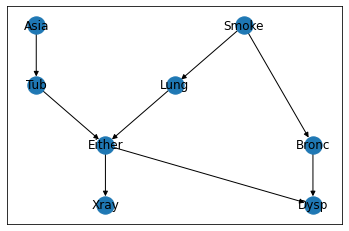

In [2]:
edges = [("Asia", "Tub"), 
         ("Smoke", "Lung"), ("Smoke", "Bronc"),
         ("Tub", "Either"),
         ("Lung", "Either"),
         ("Either", "Xray"), ("Either", "Dysp"),
         ("Bronc", "Dysp")]
layout = {"Asia": (0,0),
          "Smoke": (3,0),
          "Tub": (0, -1),
          "Lung": (2, -1),
          "Either": (1, -2),
          "Bronc": (4, -2),
          "Xray": (1, -3),
          "Dysp": (4, -3)}
asia_G = nx.DiGraph(edges)
asia_df = pd.read_csv("asia.csv", index_col=0)\
            .replace({"yes":1, "no":-1})
nx.draw_networkx(asia_G, pos=layout)

In [3]:
#Should be no issues here...
issues = falsification.falsifications(asia_G, asia_df, max_given=2, verbose=True)

Checking d-separation: 28it [00:00, 112.83it/s]
Checking conditionals: 100%|██████████| 156/156 [00:01<00:00, 100.75it/s]


In [4]:
issues

21          (Asia, Lung, (Xray, Tub))
119      (Lung, Bronc, (Smoke, Asia))
40        (Asia, Either, (Xray, Tub))
79             (Tub, Bronc, (Smoke,))
82      (Tub, Bronc, (Smoke, Either))
83        (Tub, Bronc, (Smoke, Xray))
116    (Lung, Bronc, (Smoke, Either))
133    (Bronc, Either, (Smoke, Lung))
94        (Tub, Xray, (Either, Lung))
dtype: object+evidence

In [5]:
issues.evidence

,A,B,Given,chi^2,p-value,dof,flagged
21,Asia,Lung,"(Xray, Tub)",8.428397,0.037940,3,True
119,Lung,Bronc,"(Smoke, Asia)",8.043061,0.045130,3,True
40,Asia,Either,"(Xray, Tub)",7.857395,0.019669,2,True
79,Tub,Bronc,"(Smoke,)",7.359856,0.025225,2,True
82,Tub,Bronc,"(Smoke, Either)",9.686306,0.007882,2,True
...,...,...,...,...,...,...,...
134,Bronc,Either,"(Xray, Lung)",0.706064,0.400754,1,False
41,Asia,Either,"(Tub, Lung)",0.000000,NaN,0,False
101,Smoke,Either,"(Tub, Lung)",0.000000,NaN,0,False
124,Lung,Xray,"(Either, Tub)",0.000000,NaN,0,False


In [6]:
# Should be issues (Lung, Either) AT LEAST.
#.  Seeing issues (Lung, Xray) as well.  Is that all? 
# TODO: Check d-separations by hand...
asia_G2 = asia_G.copy()
asia_G2.remove_edge("Lung", "Either")
issues = falsification.falsifications(asia_G2, asia_df, max_given=0)
issues

6     (Smoke, Either, ())
7       (Smoke, Xray, ())
8      (Lung, Either, ())
9        (Lung, Xray, ())
10    (Bronc, Either, ())
11      (Bronc, Xray, ())
dtype: object+evidence